In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simulation_backend import Person, Scenario

In [ ]:
sims_per_scenario = 2
T = 7*16
T_control = 7*12
initial_cases = 20
onset_to_isolation = "short"
transmission_before_symptoms_percentage = 15
subclinical_prob = 0
controlled = {}
for R_0 in [2.5]:
    controlled[R_0] = []
    for rho in np.linspace(0, 1, num=6):     # [0, 0.2, 0.4, 0.6, 0.8, 1]
        cases_in_control = []
        for _ in range(sims_per_scenario):
            scen = Scenario(
                T=T,
                T_control=T_control,
                initial_cases=initial_cases,
                rho=rho,
                R_0=R_0,
                subclinical_prob=subclinical_prob,
                transmission_before_symptoms_percentage=transmission_before_symptoms_percentage,
                onset_to_isolation=onset_to_isolation,
            )
            scen.simulate()
            cases_in_control.append(scen.cases_in_control)
        controlled[R_0].append(sum([i==0 for i in cases_in_control])/sims_per_scenario)

In [ ]:
sims_per_scenario = 2
T = 7*16
T_control = 7*12
initial_cases = 20
onset_to_isolation = "short"
transmission_before_symptoms_percentage = 15
subclinical_prob = 0
controlled = {}
R_0 = 2.5

for rho in np.linspace(0, 1, num=6):     # [0, 0.2, 0.4, 0.6, 0.8, 1]
    cases_in_control = []
    for _ in range(sims_per_scenario):
        scen = Scenario(
            T=T,
            T_control=T_control,
            initial_cases=initial_cases,
            rho=rho,
            R_0=R_0,
            subclinical_prob=subclinical_prob,
            transmission_before_symptoms_percentage=transmission_before_symptoms_percentage,
            onset_to_isolation=onset_to_isolation,
        )
        scen.simulate()
        cases_in_control.append(scen.cases_in_control)
    controlled.append(sum([i==0 for i in cases_in_control])/sims_per_scenario)

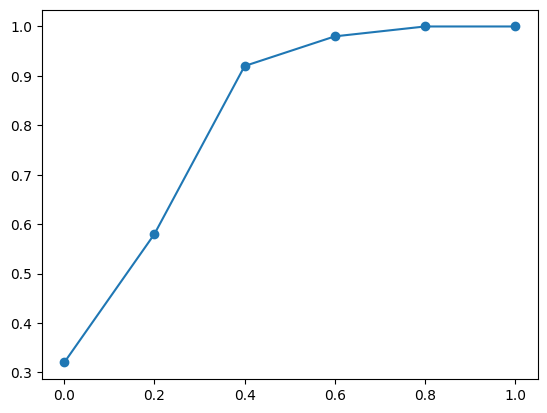

In [4]:
fig, ax = plt.subplots(1, 1)
for R_0 in [2.5]:
    ax.plot(np.linspace(0, 1, num=6), controlled[R_0], '-', marker='o', label=str(R_0))
plt.legend()